In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

#  $m=n=20$

In [4]:
m = n = 20
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(0.1 * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

mu_reg=8.6448e-03, lamb_max=1.9983e-01, mu_max=8.6448e-02


In [5]:
Z_star_1, Z_star_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [6]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [7]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2) \
                          + (mu_reg / 2) * ((Z1).pow(2).sum() + Z2.pow(2).sum())).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [8]:
print(
    f"{f_star=}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)

f_star=np.float64(-0.013250178754368415), -0.013250177726149559, 
cvxpy constraint violation: 8.624047040731164e-07


In [9]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=0.1998302912978315
obj (diag scaling):  -0.013250182382762432 
constraint viol (diag scaling):  6.295740604192468e-07
lamb_max=0.1998302912978315
obj (vanilla):  -0.013250181451439857 
constraint viol (vanilla):  8.624047040731164e-07
lamb_max=0.1998302912978315
obj (acceleration):  -0.013245527632534504 
constraint viol (acceleration):  3.159604966638391e-05
obj (fista):  -0.013250180520117283 
constraint viol (fista):  2.9384158551672146e-05


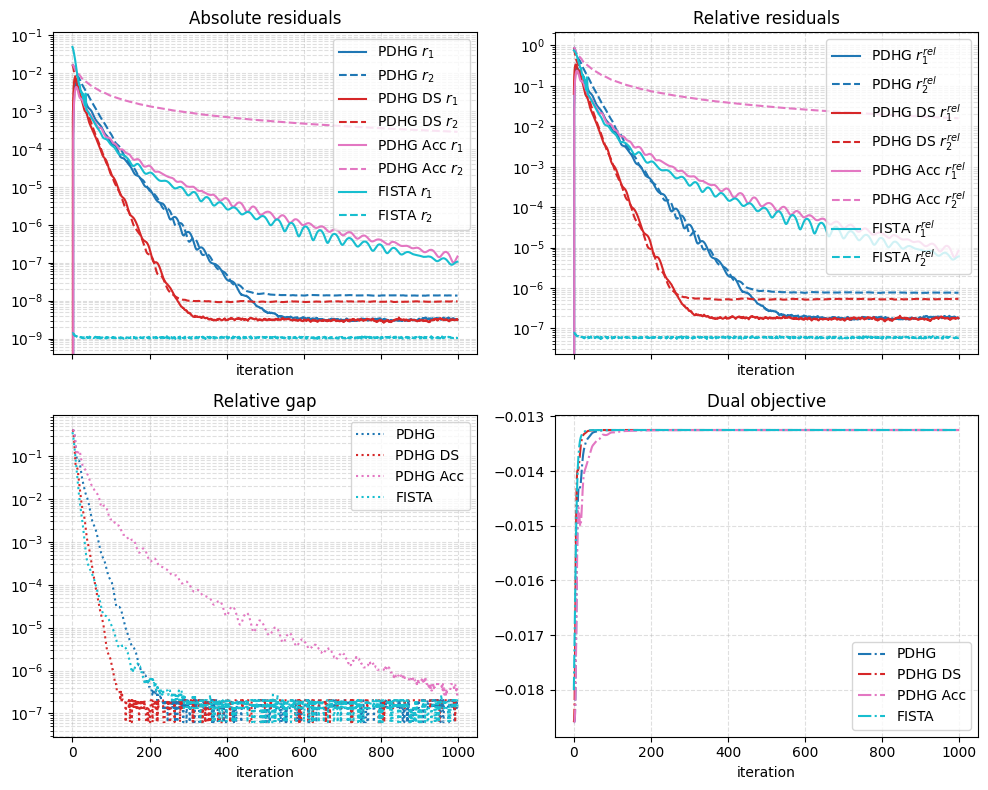

In [10]:
plot_residuals_compare(residuals, dpi=100)

#  $m=n=1000$

In [11]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(0.1 * mu_max, 1e-6)
lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

mu_reg=2.2637e-01, lamb_max=3.7596e+00, mu_max=2.2637e+00


In [12]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=9.994418640103627
obj (diag scaling):  -5.886206150054932 
constraint viol (diag scaling):  1.8790364265421078e-05
lamb_max=9.994418640103627
obj (vanilla):  -5.886207103729248 
constraint viol (vanilla):  3.8813799619653866e-05
lamb_max=9.994418640103627
obj (acceleration):  -5.878786087036133 
constraint viol (acceleration):  0.040735747665166834
obj (fista):  -5.886211395263672 
constraint viol (fista):  0.0010310215875506193


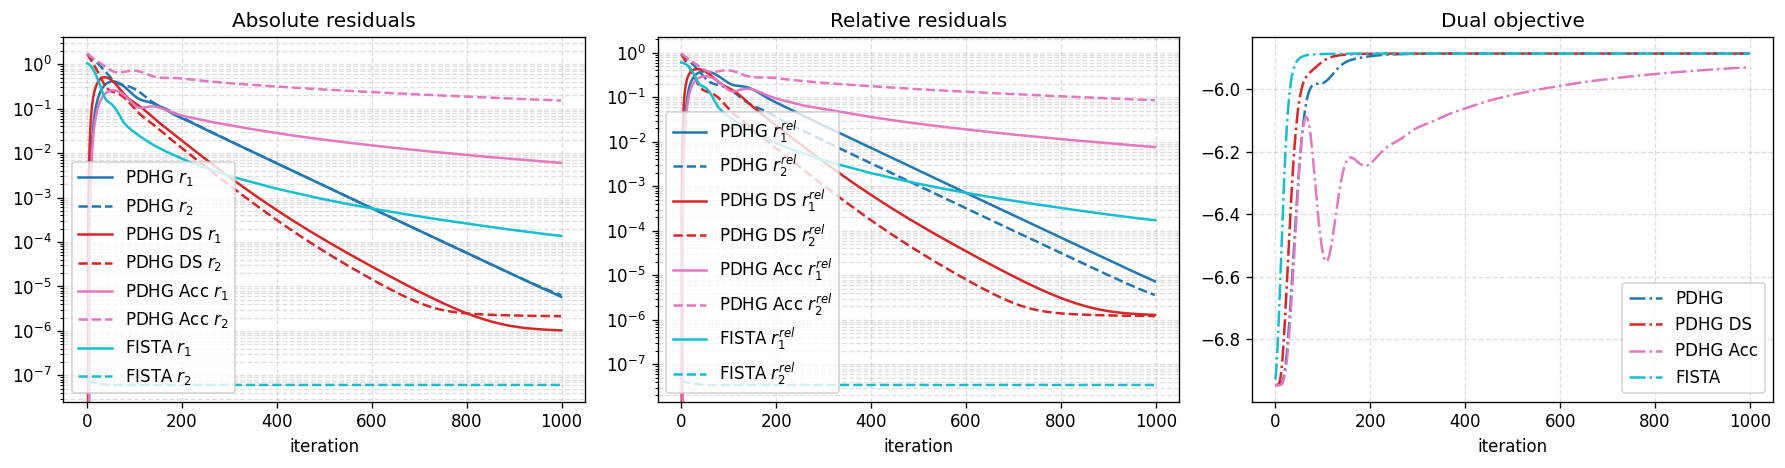

In [13]:
plot_residuals_compare(residuals)

#  $m=n=1000$

In [14]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(0.1 * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

mu_reg=2.0482e-02, lamb_max=1.0001e+01, mu_max=2.0482e-01


In [15]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            max_iter=max_iter, stopping=False, pd_residuals=pd_residuals_infty_ball)

lamb_max=10.000661943037212
obj (diag scaling):  -0.6359801292419434 
constraint viol (diag scaling):  0.04239990469068287
lamb_max=10.000661943037212
obj (vanilla):  -0.6285682916641235 
constraint viol (vanilla):  0.07889249920845029
lamb_max=10.000661943037212
obj (acceleration):  -0.5861202478408813 
constraint viol (acceleration):  0.05584459379315374
obj (fista):  -0.6363208293914795 
constraint viol (fista):  0.027191057801246622


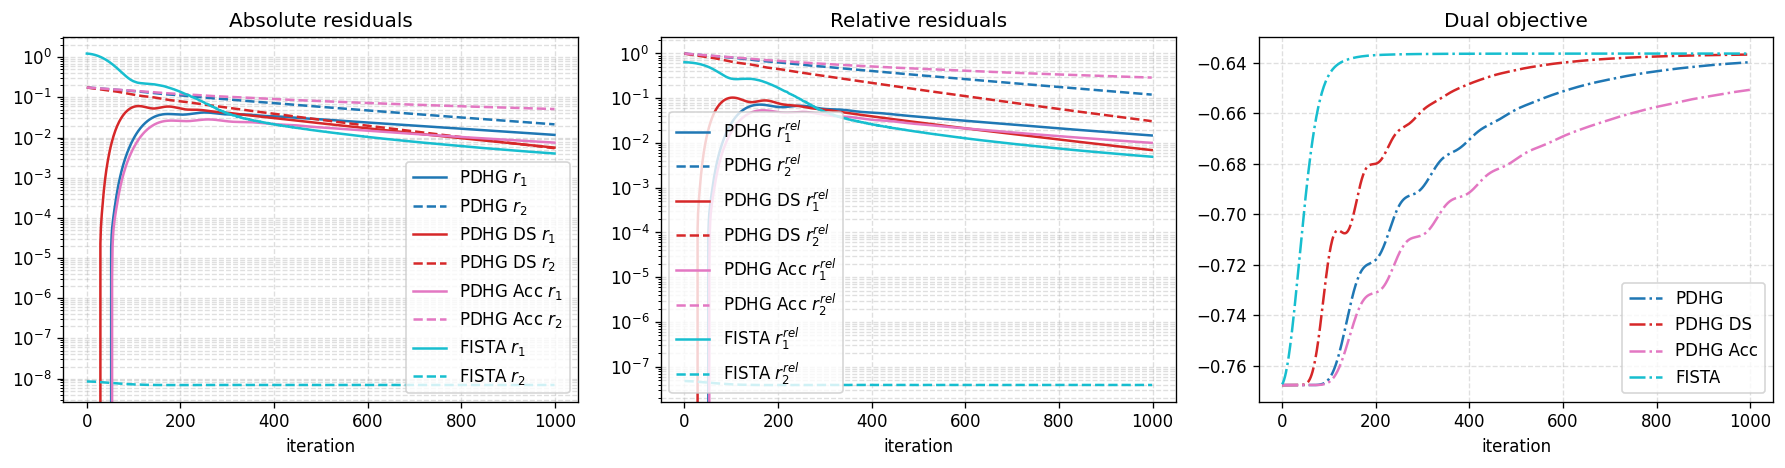

In [16]:
plot_residuals_compare(residuals)